## How often does the EPA breakdown of teams in a match correctly predict a match win?

EPA stands for Expected Points Added and is a standard for predicting individual robot contributions. In this project, I will use EPA scored for each match played by Team 4500 to create a working range at a 95% confidence interval.

EPA is similar to Elo but without the arbritary units. The downside is that it usually takes a few matches to get the EPA to a reasonably accurate value. As such, I will make two data sets, one with all the data, and another ignoring the first two matches.

In [1]:
# Example API Call

import statbotics

sb = statbotics.Statbotics()
matches = sb.get_matches(4500)

print("Year: " + str(matches[0].get('year')))
print("Match: " + str(matches[0].get('match_number')))
print("red EPA Sum: " + str(matches[0].get('red_epa_sum')))
print("blue EPA Sum: " + str(matches[0].get('blue_epa_sum')))
print("Winner: " + str(matches[0].get('winner')))
print(sb.get_matches(4500, year=2023))

/Users/sally/dev/DoesThePredictorPredict/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Year: 2013
Match: 2
red EPA Sum: 33.52
blue EPA Sum: 42.24
Winner: blue
[{'key': '2023mosl_qm7', 'year': 2023, 'event': '2023mosl', 'comp_level': 'qm', 'set_number': 1, 'match_number': 7, 'offseason': False, 'status': 'Completed', 'video': 'l_RrvDe8FX8', 'red_1': 8077, 'red_2': 931, 'red_3': 4143, 'red_dq': '', 'red_surrogate': '', 'red_epa_sum': 71.5, 'red_auto_epa_sum': 19.84, 'red_teleop_epa_sum': 33.23, 'red_endgame_epa_sum': 18.42, 'red_rp_1_epa_sum': -0.3591, 'red_rp_2_epa_sum': 0.3876, 'blue_1': 34, 'blue_2': 6744, 'blue_3': 4500, 'blue_dq': '', 'blue_surrogate': '', 'blue_epa_sum': 67.16, 'blue_auto_epa_sum': 18.64, 'blue_teleop_epa_sum': 31.22, 'blue_endgame_epa_sum': 17.3, 'blue_rp_1_epa_sum': -0.396, 'blue_rp_2_epa_sum': 0.3506, 'winner': 'red', 'epa_winner': 'red', 'epa_win_prob': 0.553, 'red_rp_1_prob': 0.0312, 'red_rp_2_prob': 0.3894, 'blue_rp_1_prob': 0.027, 'blue_rp_2_prob': 0.3549, 'playoff': False, 'time': 1678463280, 'predicted_time': 1678463116, 'red_score': 107, 'b

In [25]:
# Make Population

full_population: list[dict] = []
late_population: list[dict] = []
elim_population: list[dict] = []
TEAM_NUMBER: int = 4500
UP_TO_YEAR = 2023

def compile_all_matches():
  rookie_year = sb.get_team_years(TEAM_NUMBER)[0].get('year')
  for year in range(rookie_year, UP_TO_YEAR):
    try:
      year_matches = sb.get_matches(year=year, limit=500)
    except:
      continue
    num: int = 0
    for match in year_matches:
      full_population.append(match)


def compile_later_matches(skip: int = 2):
  rookie_year = sb.get_team_years(TEAM_NUMBER)[0].get('year')
  for year in range(rookie_year, UP_TO_YEAR):
    try:
      year_matches = sb.get_matches(year=year, limit=500)
    except:
      continue
    num: int = 0
    for match in year_matches:
      num += 1
      if (num > skip):
        late_population.append(match)

def compile_elimination_matches():
  rookie_year = sb.get_team_years(TEAM_NUMBER)[0].get('year')
  for year in range(rookie_year, UP_TO_YEAR):
    try:
      year_matches = sb.get_matches(year=year, elims=True, limit=500)
    except:
      continue
    num: int = 0
    for match in year_matches:
      elim_population.append(match)

compile_all_matches()
compile_later_matches(2)
compile_elimination_matches()

In [26]:
print(len(full_population))
print(len(elim_population))

1800
4500


### Now to Sample and Gather Proportions

In [3]:
# Sampler

import random

def get_team_pred_vals(i: dict) -> dict:
  if i.get('winner') == 'red':
    return {'isCorrect': i.get('red_epa_sum') > i.get('blue_epa_sum'), 'diff': i.get('red_score')-i.get('red_epa_sum')}
  else:
    return {'isCorrect': i.get('blue_epa_sum') > i.get('red_epa_sum'), 'diff': i.get('blue_score')-i.get('blue_epa_sum')}

# {'sample_num': sample+1, 'average_prop': float(num_corr)/float(n)}

def s_samples_of_n_size(s: int, n: int, popl: list[dict]) -> list[list[tuple]]:
  l: list[list[tuple]] = []
  for sample in range(s):
    volatile_population = popl.copy()
    li: list[tuple] = []
    for item in range(n):
      ri = random.randint(0, len(volatile_population)-1)
      li.append((item, get_team_pred_vals(volatile_population.pop(ri))))
    l.append(li)
  return l

In [4]:
# Examples

print(s_samples_of_n_size(10,40,elim_population))
print(s_samples_of_n_size(10,40,full_population))
print(s_samples_of_n_size(10,40,late_population))

[[(0, {'isCorrect': True, 'diff': 28.409999999999997}), (1, {'isCorrect': True, 'diff': 54.79}), (2, {'isCorrect': True, 'diff': -46.55000000000001}), (3, {'isCorrect': False, 'diff': 48.0}), (4, {'isCorrect': True, 'diff': 16.480000000000004}), (5, {'isCorrect': True, 'diff': 15.299999999999997}), (6, {'isCorrect': True, 'diff': 3.6099999999999994}), (7, {'isCorrect': True, 'diff': 32.97}), (8, {'isCorrect': False, 'diff': 53.47999999999999}), (9, {'isCorrect': True, 'diff': 43.09}), (10, {'isCorrect': True, 'diff': 65.38999999999999}), (11, {'isCorrect': True, 'diff': 18.689999999999998}), (12, {'isCorrect': False, 'diff': 3.9099999999999966}), (13, {'isCorrect': True, 'diff': -1.7199999999999989}), (14, {'isCorrect': False, 'diff': 76.13}), (15, {'isCorrect': False, 'diff': 9.129999999999995}), (16, {'isCorrect': True, 'diff': -11.049999999999997}), (17, {'isCorrect': True, 'diff': 52.44}), (18, {'isCorrect': True, 'diff': 18.14}), (19, {'isCorrect': True, 'diff': 5.280000000000001}

In [5]:
# Get Usable Samples

SAMPLE_SIZE = 40

# Full

f_sample = s_samples_of_n_size(1, SAMPLE_SIZE, full_population)
print(f_sample)

# Elim

e_sample = s_samples_of_n_size(1, SAMPLE_SIZE, elim_population)
print(e_sample)

# Two Match Late

l_sample = s_samples_of_n_size(1, SAMPLE_SIZE, late_population)
print(l_sample)


[[(0, {'isCorrect': True, 'diff': 25.1}), (1, {'isCorrect': True, 'diff': 18.0}), (2, {'isCorrect': True, 'diff': 7.18}), (3, {'isCorrect': False, 'diff': -28.590000000000003}), (4, {'isCorrect': True, 'diff': -65.00999999999999}), (5, {'isCorrect': True, 'diff': 7.340000000000003}), (6, {'isCorrect': False, 'diff': 48.28}), (7, {'isCorrect': True, 'diff': 0.6199999999999974}), (8, {'isCorrect': True, 'diff': -15.950000000000003}), (9, {'isCorrect': False, 'diff': 20.92}), (10, {'isCorrect': False, 'diff': 1.009999999999998}), (11, {'isCorrect': False, 'diff': -66.89}), (12, {'isCorrect': True, 'diff': 12.159999999999997}), (13, {'isCorrect': True, 'diff': 21.759999999999998}), (14, {'isCorrect': False, 'diff': 30.61}), (15, {'isCorrect': True, 'diff': 7.82}), (16, {'isCorrect': False, 'diff': 9.64}), (17, {'isCorrect': True, 'diff': 10.960000000000008}), (18, {'isCorrect': True, 'diff': -4.920000000000002}), (19, {'isCorrect': False, 'diff': 19.230000000000004}), (20, {'isCorrect': Tr

## Choose

Inference Method: One Sample Z-Interval for $p$.

Parameter: p is the true proportion of matches in which EPA correctly determined a win.

Confidence: 90%

In [22]:
print("full_population_N:", len(full_population))
print("elim_population_N:", len(elim_population))
print("late_population_N:", len(late_population))

full_population_N: 1800
elim_population_N: 45
late_population_N: 1782


## Conditions

### Random

Each item in the sample was chosen from the population using a random number generator. This allows us to generalize the results to the population.

### Independence

We are sampling without replacement, so we need to check the 10% condition to allow us to use the STDEV equations.

The code segment above finds the N values of the different populations (full, elims, late) . Here are the current N values:

full_population_N: 242

elim_population_N: 55

late_population_N: 226

I am choosing a population size of 40 since there are not 68 matches in the elim population.

Since $40 > 0.1 \cdot 242$, we do not pass the independance check. This means we should not use the STDEV formulas, but we will continue for the sake of the problem.
The same can be said for the rest of the populations, especially the elim population, as 40 is much greater than 10% of 55

### Normality

The normality check allows us to use a normal distribution to model the data.

We will check Large Counts as this is a proportions problem.

This means:
$$n\hat{p} \geq 10$$
$$n(1-\hat{p}) \geq 10$$

We usually check the parameter proportion, but since that is unknown, we use the point estimate $\hat{p}$.

Example Sample Proportions:

full: 0.7

elims: 0.675

late: 0.575

As an example case, $40 \cdot 0.7 > 10$ and $40 \cdot 0.3 > 10$, so we can assume normality for the full (assuming the independence check would have been good). Same for others as well, (not shown)

In [7]:
# See sample proportion

n = 40
num_corr = 0
for i in f_sample[0]:
  if (i[1].get('isCorrect')):
    num_corr+=1
f_prop = float(num_corr)/float(n)
print(f_prop)

num_corr = 0
for i in e_sample[0]:
  if (i[1].get('isCorrect')):
    num_corr+=1
e_prop = float(num_corr)/float(n)
print(e_prop)

num_corr = 0
for i in l_sample[0]:
  if (i[1].get('isCorrect')):
    num_corr+=1
l_prop = float(num_corr)/float(n)
print(l_prop)


0.625
0.8
0.725


In [8]:
# invNorm calc for Z-star

from scipy.special import ndtri

print(ndtri(0.95))


1.6448536269514722


## Calculations

Since we are using 1 sample Z-Interval for p:
$$I = \hat{p} \pm MarginOfError$$
$$I = \hat{p} \pm Z^* \sqrt{\frac{\hat{p}(1-\hat{p})}{n}}$$

$Z^*$ is based on the confidence that we choose. We need to do an invNorm calculation to find the value (shown in the code segment above.). In our case, with a confidence level of 0.90, our $Z^*$ value is 1.6448536269514722.

So for the full population, in the example sample, the equation for Margin of Error is:
$$1.6448536269514722 \cdot \sqrt{\frac{0.7(1-0.7)}{40}}$$
$$1.6448536269514722 \cdot \sqrt{\frac{0.21}{40}}$$
$$1.6448536269514722 \cdot \sqrt{0.00525}$$
$$1.6448536269514722 \cdot 0.07245$$
$$0.119169$$

In [9]:
# Calculations

import math

CONFIDENCE = 0.9

z_crit = ndtri((1-CONFIDENCE)/2+CONFIDENCE)

# Margins Of Errors
f_moe = z_crit * math.sqrt((f_prop * (1-f_prop))/(SAMPLE_SIZE))
e_moe = z_crit * math.sqrt((e_prop * (1-e_prop))/(SAMPLE_SIZE))
l_moe = z_crit * math.sqrt((l_prop * (1-l_prop))/(SAMPLE_SIZE))

# Intervals
f_int_low = f_prop - f_moe
f_int_high = f_prop + f_moe
e_int_low = e_prop - e_moe
e_int_high = e_prop + e_moe
l_int_low = l_prop - l_moe
l_int_high = l_prop + l_moe

print(f_int_low, f_prop, f_int_high)

0.49909212226258315 0.625 0.7509078777374169


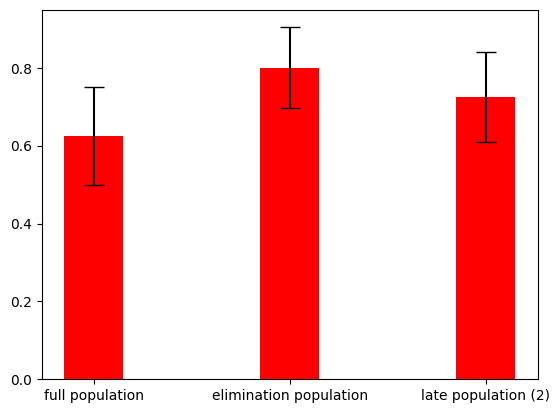

In [13]:
# See Bar Graphs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

bars = [f_prop, e_prop, l_prop]
yerrs = [f_moe, e_moe, l_moe]

plt.bar(['full population', 'elimination population', 'late population (2)'], bars, width = 0.3, color = 'red', yerr=yerrs, capsize=7, label='poacee')
plt.show()